## qwen定位

In [1]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

# ========== 配置 ==========
TEXT_DIR = '/data/guojian.li/Dataset/MSTI/Textual sentences/test'  # 假设文本在此目录
VISUAL_LABEL_DIR = '/data/guojian.li/Dataset/MSTI/Visual target labels/'
IMAGE_DIR = '/data/guojian.li/Dataset/MSTI/img'
MODEL_PATH = '/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'

# ========== VOC AP工具 ==========
def voc_ap(rec, prec, use_07_metric=False):
    if use_07_metric:
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
        i = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def voc_eval(preds, targets, threshold=0.5, use_07_metric=False):
    if len(preds) == 0:
        return 0.0
    image_ids = [x[0] for x in preds]
    confidence = np.array([float(x[1]) for x in preds])
    BB = np.array([x[2:] for x in preds])
    if BB.size == 0 or BB.ndim != 2:
        return 0.0
    sorted_ind = np.argsort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]
    npos = sum([len(targets[k]) for k in targets])
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    for d, image_id in enumerate(image_ids):
        bb = BB[d]
        if image_id in targets:
            BBGT = [gt for gt in targets[image_id]]
            match = False
            for bbgt in BBGT:
                ixmin = np.maximum(bbgt[0], bb[0])
                iymin = np.maximum(bbgt[1], bb[1])
                ixmax = np.minimum(bbgt[2], bb[2])
                iymax = np.minimum(bbgt[3], bb[3])
                iw = np.maximum(ixmax - ixmin + 1., 0.)
                ih = np.maximum(iymax - iymin + 1., 0.)
                inters = iw * ih
                union = (bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) + (bbgt[2] - bbgt[0] + 1.) * (bbgt[3] - bbgt[1] + 1.) - inters
                overlaps = inters / union if union > 0 else 0
                if overlaps > threshold:
                    tp[d] = 1
                    match = True
                    targets[image_id].remove(bbgt)
                    break
            fp[d] = 0 if match else 1
        else:
            fp[d] = 1
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos) if npos > 0 else np.zeros_like(tp)
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)
    return ap

# ========== 工具函数 ==========
def load_gt_boxes(label_file):
    gt_boxes = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            # 全为0，直接跳过
            if all(p == '0' for p in parts):
                continue
            i = 0
            while i + 4 < len(parts):
                x1, y1, x2, y2 = map(float, parts[i:i+4])
                # 目标全为0也跳过
                if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
                    i += 5
                    continue
                gt_boxes.append([x1, y1, x2, y2])
                i += 5  # 跳过class字段
    return gt_boxes

def load_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        return f.read().strip()

def parse_qwen_output(output):
    try:
        if '```json' in output:
            output = output.split('```json')[1].split('```')[0]
        boxes = json.loads(output)
        return [b['bbox_2d'] for b in boxes if 'bbox_2d' in b]
    except Exception as e:
        print('Qwen输出解析失败:', e)
        return []

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
    boxBArea = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def qwen_infer(image_path, text, prompt, model, processor):
    image = Image.open(image_path).convert('RGB')
    messages = [
        {"role": "system", "content": "你是一个图文讽刺目标定位助手"},
        {"role": "user", "content": [
            {"type": "text", "text": prompt + "\n推文内容：" + text},
            {"image": image_path}
        ]}
    ]
    text_input = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text_input], images=[image], padding=True, return_tensors="pt").to(DEVICE)
    output_ids = model.generate(**inputs, max_new_tokens=512)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]

# ========== 主流程 ==========
def main():
    print('加载Qwen2.5-VL模型...')
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2", device_map=DEVICE)
    processor = AutoProcessor.from_pretrained(MODEL_PATH)

    label_files = [f for f in os.listdir(VISUAL_LABEL_DIR) if f.endswith('.txt')]
    print(f'共{len(label_files)}张图片')

    gt_dict = {}
    pred_list = []
    em_list = []
    f1_list = []
    prompt = "请结合推文内容和图片，找出图片中被讽刺的目标，并以JSON格式输出所有目标的[x1,y1,x2,y2]像素坐标，格式为[{\"bbox_2d\":[x1,y1,x2,y2]}]。"

    for label_file in tqdm(label_files):
        imgid = os.path.splitext(label_file)[0]
        img_path = os.path.join(IMAGE_DIR, f'{imgid}.jpg')
        label_path = os.path.join(VISUAL_LABEL_DIR, label_file)
        text_path = os.path.join(TEXT_DIR, f'{imgid}.txt')
        if not (os.path.exists(img_path) and os.path.exists(text_path)):
            continue
        gt_boxes = load_gt_boxes(label_path)
        gt_dict[imgid] = [box for box in gt_boxes]  # 即使为空也要加
        text = load_text(text_path)
        output = qwen_infer(img_path, text, prompt, model, processor)
        pred_boxes = parse_qwen_output(output)
        pred_boxes = [[float(x) for x in box] for box in pred_boxes]
        # EM/F1逻辑
        if not gt_boxes and not pred_boxes:
            em = 1
            f1 = 1
        elif not gt_boxes and pred_boxes:
            em = 0
            f1 = 0
        elif gt_boxes and not pred_boxes:
            em = 0
            f1 = 0
        else:
            em = int(sorted(pred_boxes) == sorted(gt_boxes))
            matched_pred = set()
            matched_gt = set()
            for i, pb in enumerate(pred_boxes):
                for j, gb in enumerate(gt_boxes):
                    if j in matched_gt:
                        continue
                    if iou(pb, gb) >= 0.5:
                        matched_pred.add(i)
                        matched_gt.add(j)
                        break
            tp = len(matched_pred)
            fp = len(pred_boxes) - tp
            fn = len(gt_boxes) - tp
            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            f1 = 2 * precision * recall / (precision + recall + 1e-6) if (precision+recall)>0 else 0
        em_list.append(em)
        f1_list.append(f1)
        for pb in pred_boxes:
            pred_list.append([imgid, 1.0, pb[0], pb[1], pb[2], pb[3]])

    thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps = []
    for th in thresholds:
        aps.append(voc_eval(pred_list, {k: [b for b in v] for k, v in gt_dict.items()}, threshold=th))
    ap = np.mean(aps)
    ap50 = aps[0]
    ap75 = aps[5]
    print(f'EM: {np.mean(em_list):.4f}')
    print(f'F1: {np.mean(f1_list):.4f}')
    print(f'AP: {ap:.4f}')
    print(f'AP50: {ap50:.4f}')
    print(f'AP75: {ap75:.4f}')

if __name__ == '__main__':
    main()

/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-06-19 11:50:40,364] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


加载Qwen2.5-VL模型...


Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


共5015张图片


  5%|▍         | 241/5015 [00:38<12:11,  6.53it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


 10%|█         | 513/5015 [01:28<06:51, 10.94it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


 36%|███▌      | 1803/5015 [05:40<09:10,  5.84it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


 79%|███████▊  | 3937/5015 [13:06<02:09,  8.32it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


 95%|█████████▍| 4750/5015 [15:44<00:40,  6.51it/s]

Qwen输出解析失败: Expecting value: line 1 column 1 (char 0)


100%|██████████| 5015/5015 [16:26<00:00,  5.08it/s]

EM: 0.0189
F1: 0.1875
AP: 0.0275
AP50: 0.0595
AP75: 0.0262


In [ ]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

# ========== 配置 ==========
TEXT_DIR = '/data/guojian.li/Dataset/MSTI/Textual sentences/test'  # 假设文本在此目录
VISUAL_LABEL_DIR = '/data/guojian.li/Dataset/MSTI/Visual target labels/'
IMAGE_DIR = '/data/guojian.li/Dataset/MSTI/img'
# MODEL_PATH = '/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct'
MODEL_PATH = '/data/guojian.li/Project/Video-R1/src/r1-v/log/Qwen2.5-VL-7B-sarcasm-sft-lora-s2'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'


# ========== VOC AP工具 ==========
def voc_ap(rec, prec, use_07_metric=False):
    if use_07_metric:
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
        i = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def voc_eval(preds, targets, threshold=0.5, use_07_metric=False):
    if len(preds) == 0:
        return 0.0
    image_ids = [x[0] for x in preds]
    confidence = np.array([float(x[1]) for x in preds])
    BB = np.array([x[2:] for x in preds])
    if BB.size == 0 or BB.ndim != 2:
        return 0.0
    sorted_ind = np.argsort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]
    npos = sum([len(targets[k]) for k in targets])
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    for d, image_id in enumerate(image_ids):
        bb = BB[d]
        if image_id in targets:
            BBGT = [gt for gt in targets[image_id]]
            match = False
            for bbgt in BBGT:
                ixmin = np.maximum(bbgt[0], bb[0])
                iymin = np.maximum(bbgt[1], bb[1])
                ixmax = np.minimum(bbgt[2], bb[2])
                iymax = np.minimum(bbgt[3], bb[3])
                iw = np.maximum(ixmax - ixmin + 1., 0.)
                ih = np.maximum(iymax - iymin + 1., 0.)
                inters = iw * ih
                union = (bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) + (bbgt[2] - bbgt[0] + 1.) * (bbgt[3] - bbgt[1] + 1.) - inters
                overlaps = inters / union if union > 0 else 0
                if overlaps > threshold:
                    tp[d] = 1
                    match = True
                    targets[image_id].remove(bbgt)
                    break
            fp[d] = 0 if match else 1
        else:
            fp[d] = 1
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos) if npos > 0 else np.zeros_like(tp)
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)
    return ap

# ========== 工具函数 ==========
def load_gt_boxes(label_file):
    gt_boxes = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            # 全为0，直接跳过（class为0的样本）
            if all(p == '0' for p in parts):
                return []  # 直接返回空，主循环会跳过
            i = 0
            while i + 4 < len(parts):
                x1, y1, x2, y2 = map(float, parts[i:i+4])
                # 目标全为0也跳过
                if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
                    i += 5
                    continue
                gt_boxes.append([x1, y1, x2, y2])
                i += 5  # 跳过class字段
    return gt_boxes

def load_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        return f.read().strip()

def parse_qwen_output(output):
    try:
        if '```json' in output:
            output = output.split('```json')[1].split('```')[0]
        boxes = json.loads(output)
        return [b['bbox_2d'] for b in boxes if 'bbox_2d' in b]
    except Exception as e:
        print(output)
        print('Qwen输出解析失败:', e)
        return []

def qwen_infer(image_path, text, prompt, model, processor):
    image = Image.open(image_path).convert('RGB')
    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": [
            {"type": "text", "text": prompt + "\nText of tweet:" + text},
            {"image": image_path}
        ]}
    ]
    text_input = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text_input], images=[image], padding=True, return_tensors="pt").to(DEVICE)
    output_ids = model.generate(**inputs, max_new_tokens=1024)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]

# ========== 主流程 ==========
def main():
    print('加载Qwen2.5-VL模型...')
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2", device_map=DEVICE)
    processor = AutoProcessor.from_pretrained(MODEL_PATH)

    label_files = [f for f in os.listdir(VISUAL_LABEL_DIR) if f.endswith('.txt')]
    print(f'共{len(label_files)}张图片')

    num_images = 0 # 实际图片数量

    gt_dict = {}
    pred_list = []
    prompt = ("Please combine the content of the tweet and the pictures to identify the targets being ridiculed in the pictures, "
    "and output the pixel coordinates of all the targets in JSON format. "
    "in formats such as [{\"bbox_2d\":[x1,y1,x2,y2]},{\"bbox_2d\":[x1,y1,x2,y2]}]. If it does not exist, return [].")

    for label_file in tqdm(label_files):
        imgid = os.path.splitext(label_file)[0]
        img_path = os.path.join(IMAGE_DIR, f'{imgid}.jpg')
        label_path = os.path.join(VISUAL_LABEL_DIR, label_file)
        text_path = os.path.join(TEXT_DIR, f'{imgid}.txt')
        if not (os.path.exists(img_path) and os.path.exists(text_path)):
            continue
        gt_boxes = load_gt_boxes(label_path)
        # 跳过class为0的样本（即gt_boxes==[]）
        if not gt_boxes:
            continue
        num_images += 1
        gt_dict[imgid] = [box for box in gt_boxes]
        text = load_text(text_path)
        output = qwen_infer(img_path, text, prompt, model, processor)
        pred_boxes = parse_qwen_output(output)
        pred_boxes = [[float(x) for x in box] for box in pred_boxes]
        for pb in pred_boxes:
            pred_list.append([imgid, 1.0, pb[0], pb[1], pb[2], pb[3]])

    thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps = []
    for th in thresholds:
        aps.append(voc_eval(pred_list, {k: [b for b in v] for k, v in gt_dict.items()}, threshold=th))
    ap = np.mean(aps)
    ap50 = aps[0]
    ap75 = aps[5]
    print(f'处理了{num_images}张图片')
    print(f'AP: {ap:.4f}')
    print(f'AP50: {ap50:.4f}')
    print(f'AP75: {ap75:.4f}')

if __name__ == '__main__':
    main()

/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-07-07 15:40:35,065] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


加载Qwen2.5-VL模型...


Loading checkpoint shards: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


共5015张图片


100%|██████████| 5015/5015 [03:31<00:00, 23.69it/s]

处理了419张图片
AP: 0.0021
AP50: 0.0057
AP75: 0.0019


In [ ]:
处理了419张图片
AP: 0.0175
AP50: 0.0380
AP75: 0.0182

lora2
处理了419张图片
AP: 0.0010
AP50: 0.0032
AP75: 0.0010

lora3
处理了419张图片
AP: 0.0027
AP50: 0.0072
AP75: 0.0019

sft
AP: 0.0157
AP50: 0.0392
AP75: 0.0115
修改后


sft
处理了419张图片
AP: 0.0080
AP50: 0.0193
AP75: 0.0062


[]

In [1]:
import os
import json
import torch
from peft import PeftModel
from PIL import Image
from tqdm import tqdm
import numpy as np
import ast
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

# ========== 配置 ==========
TEXT_DIR = '/data/guojian.li/Dataset/MSTI/Textual sentences/test'  # 假设文本在此目录
VISUAL_LABEL_DIR = '/data/guojian.li/Dataset/MSTI/Visual target labels/'
IMAGE_DIR = '/data/guojian.li/Dataset/MSTI/img'
MODEL_PATH = '/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct'
# MODEL_PATH = '/data/guojian.li/Project/Video-R1/src/r1-v/log/Qwen2.5-VL-7B-sarcasm-sft-lora-s4'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'


# ========== VOC AP工具 ==========
def voc_ap(rec, prec, use_07_metric=False):
    if use_07_metric:
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
        i = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def voc_eval(preds, targets, threshold=0.5, use_07_metric=False):
    if len(preds) == 0:
        return 0.0
    image_ids = [x[0] for x in preds]
    confidence = np.array([float(x[1]) for x in preds])
    BB = np.array([x[2:] for x in preds])
    if BB.size == 0 or BB.ndim != 2:
        return 0.0
    sorted_ind = np.argsort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]
    npos = sum([len(targets[k]) for k in targets])
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    for d, image_id in enumerate(image_ids):
        bb = BB[d]
        if image_id in targets:
            BBGT = [gt for gt in targets[image_id]]
            match = False
            for bbgt in BBGT:
                ixmin = np.maximum(bbgt[0], bb[0])
                iymin = np.maximum(bbgt[1], bb[1])
                ixmax = np.minimum(bbgt[2], bb[2])
                iymax = np.minimum(bbgt[3], bb[3])
                iw = np.maximum(ixmax - ixmin + 1., 0.)
                ih = np.maximum(iymax - iymin + 1., 0.)
                inters = iw * ih
                union = (bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) + (bbgt[2] - bbgt[0] + 1.) * (bbgt[3] - bbgt[1] + 1.) - inters
                overlaps = inters / union if union > 0 else 0
                if overlaps > threshold:
                    tp[d] = 1
                    match = True
                    targets[image_id].remove(bbgt)
                    break
            fp[d] = 0 if match else 1
        else:
            fp[d] = 1
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos) if npos > 0 else np.zeros_like(tp)
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)
    return ap

# ========== 工具函数 ==========
def load_gt_boxes(label_file):
    gt_boxes = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            i = 0
            while i + 3 < len(parts):
                step = 5 if i + 4 < len(parts) else 4
                x1, y1, x2, y2 = map(float, parts[i:i+4])
                 # 目标全为0也跳过
                if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
                    i += step
                    continue
                gt_boxes.append([x1, y1, x2, y2])
                i += step
    return gt_boxes

def load_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        return f.read().strip()

def parse_qwen_output(output):
    try:
        if '```json' in output:
            output = output.split('```json')[1].split('```')[0]
        # boxes = json.loads(output)
        boxes = ast.literal_eval(output)
        return [b['bbox_2d'] for b in boxes if 'bbox_2d' in b]
    except Exception as e:
        print(output)
        print('Qwen输出解析失败:', e)
        return []

def qwen_infer(image_path, text, prompt, model, processor):
    image = Image.open(image_path).convert('RGB')
    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": [
            {"image": image_path},
            {"type": "text", "text": prompt + "\nThe provided text is as follows:\n" + text},
        ]}
    ]
    text_input = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text_input], images=[image], padding=True, return_tensors="pt").to(DEVICE)
    output_ids = model.generate(**inputs, max_new_tokens=1024)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]

# ========== 主流程 ==========
def main():
    print('加载Qwen2.5-VL模型...')
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2", device_map=DEVICE)
    processor = AutoProcessor.from_pretrained(MODEL_PATH)

    LORA_PATH = '/data/guojian.li/Project/Video-R1/src/r1-v/log/Qwen2.5-VL-7B-sarcasm-sft-lora-s4'

    # 加载 LoRA 适配器
    model = PeftModel.from_pretrained(
        model,
        LORA_PATH,  # LoRA 适配器所在的目录
        torch_dtype=torch.bfloat16,
        device_map=DEVICE
    )

    # model = model.merge_and_unload()

    text_files = [f for f in os.listdir(TEXT_DIR) if f.endswith('.txt')]
    print(f'共{len(text_files)}张数据')

    num_images = 0 # 实际图片数量

    gt_dict = {}
    pred_list = []
    prompt = ('Please combine the content of the tweet and the pictures to identify the targets being sarcastic in the pictures. '
    'The target of satire may be more than one, or there may be none. '
    'If they exist, output the pixel coordinates of all the targets,'
    'in formats such as [{"bbox_2d":[x1,y1,x2,y2]},{"bbox_2d":[x1,y1,x2,y2]}]. If it does not exist, return [].'
    'The answer only provides the coordinates.')
    
    for text_file in tqdm(text_files):
        imgid = os.path.splitext(text_file)[0]
        img_path = os.path.join(IMAGE_DIR, f'{imgid}.jpg')
        label_path = os.path.join(VISUAL_LABEL_DIR, text_file)
        text_path = os.path.join(TEXT_DIR, f'{imgid}.txt')
        if not (os.path.exists(img_path) and os.path.exists(text_path)):
            continue
        gt_boxes = load_gt_boxes(label_path)
        num_images += 1
        gt_dict[imgid] = [box for box in gt_boxes]
        text = load_text(text_path)
        output = qwen_infer(img_path, text, prompt, model, processor)
        
        with open("./data/output3.txt", "a", encoding="utf-8") as file:
            file.write("\n1." + output)  # 追加一行
            file.write("\n2." + str(gt_boxes))  

        pred_boxes = parse_qwen_output(output)
        try:
            pred_boxes = [[float(x) for x in box] for box in pred_boxes]
        except Exception as e:
            print(pred_boxes)
            print('坐标错误:', e)
            continue
        for pb in pred_boxes:
            pred_list.append([imgid, 1.0, pb[0], pb[1], pb[2], pb[3]])
           

    thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    aps = []
    for th in thresholds:
        aps.append(voc_eval(pred_list, {k: [b for b in v] for k, v in gt_dict.items()}, threshold=th))
    ap = np.mean(aps)
    ap50 = aps[0]
    ap75 = aps[5]
    print(f'处理了{num_images}张图片')
    print(f'AP: {ap:.4f}')
    print(f'AP50: {ap50:.4f}')
    print(f'AP75: {ap75:.4f}')

if __name__ == '__main__':
    main()

/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-07-09 15:25:57,641] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


加载Qwen2.5-VL模型...


Loading checkpoint shards: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


共742张数据


100%|██████████| 742/742 [17:24<00:00,  1.41s/it]

处理了742张图片
AP: 0.0119
AP50: 0.0230
AP75: 0.0124


In [ ]:
改了prompt后的

lora-s3
处理了742张图片
AP: 0.0140
AP50: 0.0267
AP75: 0.0138
处理了3546张图片
AP: 0.0123
AP50: 0.0214
AP75: 0.0125
合并后
AP: 0.0114
AP50: 0.0252
AP75: 0.0092

lora-s4 解冻visual
处理了742张图片
AP: 0.0083
AP50: 0.0171
AP75: 0.0079


lora-s2
处理了742张图片
AP: 0.0028
AP50: 0.0077
AP75: 0.0012

lora3
处理了742张图片
AP: 0.0056
AP50: 0.0149
AP75: 0.0030

In [1]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
import numpy as np
from peft import PeftModel
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

TEXT_DIR = '/data/guojian.li/Dataset/MSTI/Textual sentences/test'  # 假设文本在此目录
VISUAL_LABEL_DIR = '/data/guojian.li/Dataset/MSTI/Visual target labels/'
IMAGE_DIR = '/data/guojian.li/Dataset/MSTI/img'
MODEL_PATH = '/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct'
# MODEL_PATH = '/data/guojian.li/Project/Video-R1/src/r1-v/log/Qwen2.5-VL-7B-sarcasm-sft-lora-s4'
DEVICE = 'cuda:7' if torch.cuda.is_available() else 'cpu'

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, attn_implementation="flash_attention_2", device_map=DEVICE)
processor = AutoProcessor.from_pretrained(MODEL_PATH)

LORA_PATH = '/data/guojian.li/Project/Video-R1/src/r1-v/log/Qwen2.5-VL-7B-sarcasm-sft-lora-s4'

    # 加载 LoRA 适配器
model = PeftModel.from_pretrained(
        model,
        LORA_PATH,  # LoRA 适配器所在的目录
        torch_dtype=torch.bfloat16,
        device_map=DEVICE
)


/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-07-09 15:01:36,057] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import xml.etree.ElementTree as ET

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    # print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      print(f"修改后的坐标 {i}: ({abs_x1}, {abs_y1}), ({abs_x2}, {abs_y2})")

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color, font=font)
  
  img.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [7]:
def qwen_infer(image_path, text, prompt, model, processor):
    image = Image.open(image_path).convert('RGB')
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": [
            {"image": image_path},
            {"type": "text", "text": prompt + "\content of the tweet" + text}
        ]}
    ]
    text_input = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text_input], images=[image], padding=True, return_tensors="pt").to(DEVICE)
    output_ids = model.generate(**inputs, max_new_tokens=512)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

      # 在源码处理中，除以了patch大小，这里需要乘回来
    input_height = inputs['image_grid_thw'][0][1]*14
    input_width = inputs['image_grid_thw'][0][2]*14

    return output_text[0], input_height, input_width

def load_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        return f.read().strip()
    
def load_gt_boxes(label_file):
    gt_boxes = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            # 全为0，直接跳过（class为0的样本）
            if all(p == '0' for p in parts):
                return []  # 直接返回空，主循环会跳过
            i = 0
            while i + 4 < len(parts):
                x1, y1, x2, y2 = map(float, parts[i:i+4])
                # 目标全为0也跳过
                if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
                    i += 5
                    continue
                gt_boxes.append([x1, y1, x2, y2])
                i += 5  # 跳过class字段
    return gt_boxes

[[195.0, 238.0, 225.0, 335.0], [229.0, 239.0, 272.0, 352.0], [256.0, 242.0, 299.0, 348.0], [277.0, 241.0, 317.0, 346.0], [349.0, 252.0, 384.0, 341.0], [373.0, 256.0, 409.0, 356.0], [465.0, 243.0, 500.0, 347.0], [490.0, 238.0, 524.0, 354.0]]
修改后的坐标 0: (195, 238), (225, 335)
修改后的坐标 1: (229, 239), (272, 352)
修改后的坐标 2: (256, 242), (299, 348)
修改后的坐标 3: (277, 241), (317, 346)
修改后的坐标 4: (349, 252), (384, 341)
修改后的坐标 5: (373, 256), (409, 356)
修改后的坐标 6: (465, 243), (500, 347)
修改后的坐标 7: (490, 238), (524, 354)


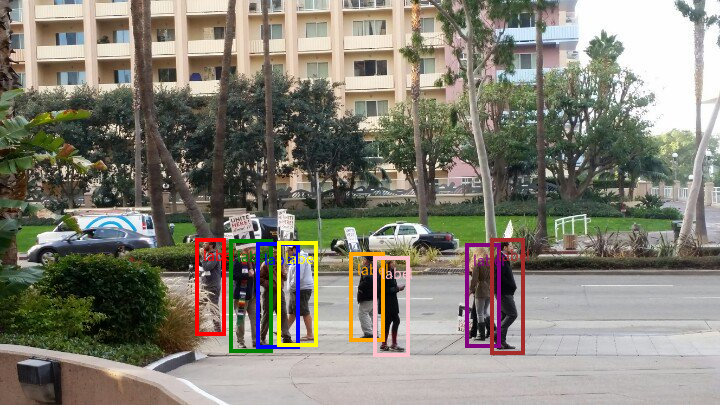

In [8]:
img_path = "/data/guojian.li/Dataset/MSTI/img/2227.jpg"
image = Image.open(img_path)
label_path = os.path.join(VISUAL_LABEL_DIR, '2227.txt')
label = load_gt_boxes(label_path)
print(label)
labels = []
for box in label:
    labels.append({
        "bbox_2d": box,
        "label": "label"
    })
plot_bounding_boxes(image,str(labels),image.size[0],image.size[1])

推文： # westin and # rennaisance workers protesting unreasonable hours , lack of tools , safety concerns # suchwhiners
真实尺寸： (720, 405)
变换后尺寸： tensor(728, device='cuda:7') tensor(392, device='cuda:7')
真实坐标 [[195.0, 238.0, 225.0, 335.0], [229.0, 239.0, 272.0, 352.0], [256.0, 242.0, 299.0, 348.0], [277.0, 241.0, 317.0, 346.0], [349.0, 252.0, 384.0, 341.0], [373.0, 256.0, 409.0, 356.0], [465.0, 243.0, 500.0, 347.0], [490.0, 238.0, 524.0, 354.0]]
模型回答 ```json
[
	{"bbox_2d": [198, 230, 227, 324], "label": "object being ridiculed"},
	{"bbox_2d": [231, 226, 265, 337], "label": "object being ridiculed"},
	{"bbox_2d": [262, 236, 298, 337], "label": "object being ridiculed"},
	{"bbox_2d": [289, 235, 322, 331], "label": "object being ridiculed"},
	{"bbox_2d": [360, 244, 386, 332], "label": "object being ridiculed"},
	{"bbox_2d": [382, 247, 410, 340], "label": "object being ridiculed"},
	{"bbox_2d": [466, 238, 499, 330], "label": "object being ridiculed"},
	{"bbox_2d": [498, 232, 523, 338], "label":

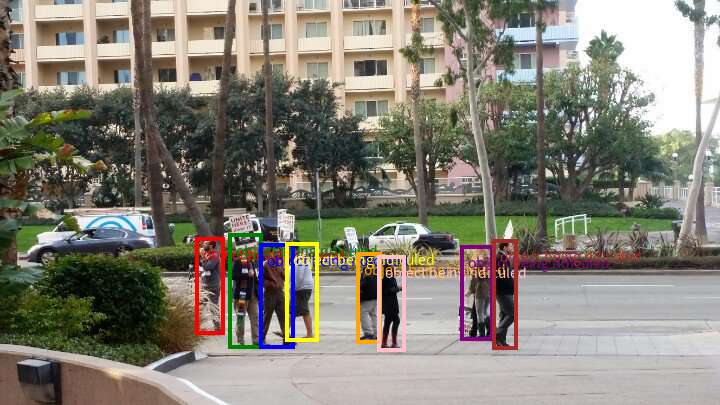

In [9]:
text_path = "/data/guojian.li/Dataset/MSTI/Textual sentences/train/2227.txt"
img_path = "/data/guojian.li/Dataset/MSTI/img/2227.jpg"
image1 = Image.open(img_path)
text = load_text(text_path)
print("推文：",text)
prompt = ("Please combine the content of the tweet with the picture and find all the objects being ridiculed in the picture."
          "Try to position each target separately as much as possible."
"There might be multiple targets. Output all the coordinates in JSON format.")
response, input_height, input_width = qwen_infer(img_path, text, prompt, model, processor)
print("真实尺寸：",image1.size)
print("变换后尺寸：",input_width,input_height)
print("真实坐标",label)
print("模型回答",response)

plot_bounding_boxes(image1,response,input_width,input_height)

In [2]:
import os,re
import json
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def inference(image_path, prompt, sys_prompt="""You are a helpful assistant
   """, 
max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda:1')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

# 路径配置
MODEL_PATH = "/data/guojian.li/Weight/Qwen2.5-VL-7B-Instruct/"
IMG_DIR = "/data/guojian.li/Dataset/MMSD/dataset_image/"
DATA_JSON = "/data/guojian.li/Dataset/MMSD/text_json_final/test.json"

# 加载模型与处理器
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, 
                                                           attn_implementation="flash_attention_2",device_map=device)
processor = AutoProcessor.from_pretrained(MODEL_PATH)

def predict_sarcasm(image_path, text):
    # image = Image.open(image_path).convert("RGB")
    prompt = (
        f""" 
            Please output strictly in accordance with the following XML-like structure:\n
            '<think> Natural Language Interpretation </think><bbox_2d> coordinates or none</bbox_2d><answer> sarcasm/non-sarcasm </answer>'\n\n
            Explanation:\n
            1. In <think> Explain 'Why judge (not) sarcasm'.\n
            2. <bbox_2d> section:\n
                If answer= sarcasm, give the coordinates of satirical target:'[x1,y1,x2,y2],[x1,y1,x2,y2]'. 
                    The target of satire may be more than one, or there may be none. If not, write single token 'none'.\n
                If answer= non-sarcasm, write single token 'none'.\n
            3. Only output the above three tags. The order of the tags cannot be changed. The tag name, Angle brackets, and slashes must be complete.\n\n

            Text:{text}\n
            Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.\n
            There are only two categories: sarcasm and non-sarcasm. Just output it in the prescribed format. No extra text is needed.
        """
    )
    # inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    # outputs = model.generate(**inputs, max_new_tokens=20)
    # response = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

    response = inference(image_path, prompt)

    with open("./data/output2.txt", "a", encoding="utf-8") as file:
        file.write("\n" + response)  # 追加一行

    match = re.search(r'<answer>(.*?)</answer>', string=response)

    if match:
        answer = match.group(1)
        # 简单的输出判定，可根据实际微调
        if "sarcasm" == answer:
            return 1
        else:
            return 0
    else:
        print(f"未能正确解析响应: {response}")
        return 1

def main():
    with open(DATA_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)

    y_true, y_pred = [], []
    for item in tqdm(data):
        image_id = item["image_id"]
        text = item["text"]
        label = item["label"]
        image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            print(f"图片不存在: {image_path}")
            continue
        pred_label = predict_sarcasm(image_path, text)
        y_true.append(label)
        y_pred.append(pred_label)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"准确率: {acc:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")

if __name__ == "__main__":
    main()


  2%|▏         | 52/2409 [03:21<2:32:16,  3.88s/it]


KeyboardInterrupt: 

In [1]:
import os,re
import json
from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


def inference(image_path, prompt, sys_prompt=(
"You are a multimodal satire analysis assistant.\n"
    "Please output strictly in accordance with the following structure:\n"
    "'<think>Natural Language Interpretation</think> <bbox_2d>coordinates or none</bbox_2d> <answer>sarcasm/non-sarcasm</answer> '\n\n"
    
    "Explanation:\n"
    "1. In <think> Explain 'Why judge (not) sarcasm'.\n"
    "2. <bbox_2d> section:\n"
        "If answer= sarcasm, give the coordinates of satirical target '[x1,y1,x2,y2] ,[x1,y1,x2,y2]'. "
        "The target of satire may be more than one, or there may be none. If not, write single token 'none'.\n"
        "If answer= non-sarcasm, write single token 'none'."
    "3. Only output the above three tags. The order of the tags cannot be changed. The tag name, Angle brackets, and slashes must be complete.\n\n"
    
    "The following are some relevant examples:\n"
    "1.An example of satire:\n"
        "<think>The description of the environment in the text does not match the promotion, and irony is used to express satire.</think> "
        "<bbox_2d>[23,45,44,78],[10,20,32,40]</bbox_2d> <answer>sarcasm</answer> \n"
    "2.An example of non-sarcasm:\n"
        "<think>The text normally describes the feelings brought by fine weather, without any sarcasm.</think> "
        "<bbox_2d>none</bbox_2d> <answer>non-sarcasm</answer> "
), 
max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda:2')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]

# 路径配置
MODEL_PATH = "/data/guojian.li/Project/Video-R1/src/r1-v/log/Qwen2.5-VL-7B-sarcasm-sft-s1"
IMG_DIR = "/data/guojian.li/Dataset/MMSD/dataset_image/"
DATA_JSON = "/data/guojian.li/Dataset/MMSD/text_json_final/test.json"

# 加载模型与处理器
device = "cuda:2" if torch.cuda.is_available() else "cpu"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_PATH, torch_dtype=torch.bfloat16, 
                                                           attn_implementation="flash_attention_2",device_map=device)
processor = AutoProcessor.from_pretrained(MODEL_PATH)

def predict_sarcasm(image_path, text):
    # image = Image.open(image_path).convert("RGB")
    prompt = (
        f"""
            Text:{text}\n
            Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
            You need to think step by step and carefully analyze the relationship between the text and the images. Just output it in the prescribed format. No extra text is needed.
        """
    )
    # inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    # outputs = model.generate(**inputs, max_new_tokens=20)
    # response = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

    response = inference(image_path, prompt)

    with open("./data/output2.txt", "a", encoding="utf-8") as file:
        file.write("\n" + response)  # 追加一行


    match = re.search(r'<answer>(.*?)</answer>', string=response)

    if match:
        answer = match.group(1)
        # 简单的输出判定，可根据实际微调
        if "sarcasm" == answer:
            return 1
        else:
            return 0
    else:
        print(f"未能正确解析响应: {response}")
        return 1

def main():
    with open(DATA_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)

    y_true, y_pred = [], []
    for item in tqdm(data):
        image_id = item["image_id"]
        text = item["text"]
        label = item["label"]
        image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            print(f"图片不存在: {image_path}")
            continue
        pred_label = predict_sarcasm(image_path, text)
        y_true.append(label)
        y_pred.append(pred_label)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"准确率: {acc:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")

if __name__ == "__main__":
    main()


/opt/conda/envs/video-r1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-07-07 19:11:30,492] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/opt/conda/envs/video-r1/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
  0%|          | 2/2409 [02:22<55:14:56, 82.63s/it]

未能正确解析响应: Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
You need to think step by step and carefully analyze the relationship between the text and the images. Just output it in the prescribed format. No extra text is needed.
Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
You need to think step by step and carefully analyze the relationship between the text and the images. Just output it in the prescribed format. No extra text is needed.
Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
You need to think step by step and carefully analyze the relationship between the text and the images. Just output it in the prescribed format. No extra text is needed.
Please judge whether this picture and text are satirical. If so, point out the locat

  0%|          | 4/2409 [04:40<54:35:49, 81.73s/it]

未能正确解析响应: Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
Please judge whether this picture and text are satirical. If so, point out the location of the satirical target and give the reason.
Please judge whether this picture and text are satirical. I

  0%|          | 4/2409 [06:06<61:15:35, 91.70s/it]


KeyboardInterrupt: 